<div dir="rtl">

#פרויקט מערכת איזון אוטונומית מבוססת למידת חיזוקים


## פרטי הפרויקט
- **תאריך:** 16 בינואר 2025
- **מגיש:** אייל פורת
- **מרצה:** שי פרח

## סקירה כללית
פרויקט זה מיישם מערכת איזון אוטונומית המבוססת על למידת חיזוקים (Reinforcement Learning). המערכת מיועדת לשלוט ברובוט דו-גלגלי ולשמור עליו במצב מאוזן תוך כדי תנועה.

### רכיבי המערכת העיקריים:
1. **סביבת סימולציה**: מדמה את הפיזיקה של הרובוט הדו-גלגלי
2. **אלגוריתם DDPG**: מאמן את הרובוט לשמור על איזון
3. **מערכת תצוגה**: מאפשרת הדמיה ויזואלית של התהליך

זהו השלב הראשון בפרויקט, בו נגיע לאלגוריתם מאומן על סביבת הסימולציה

</div>

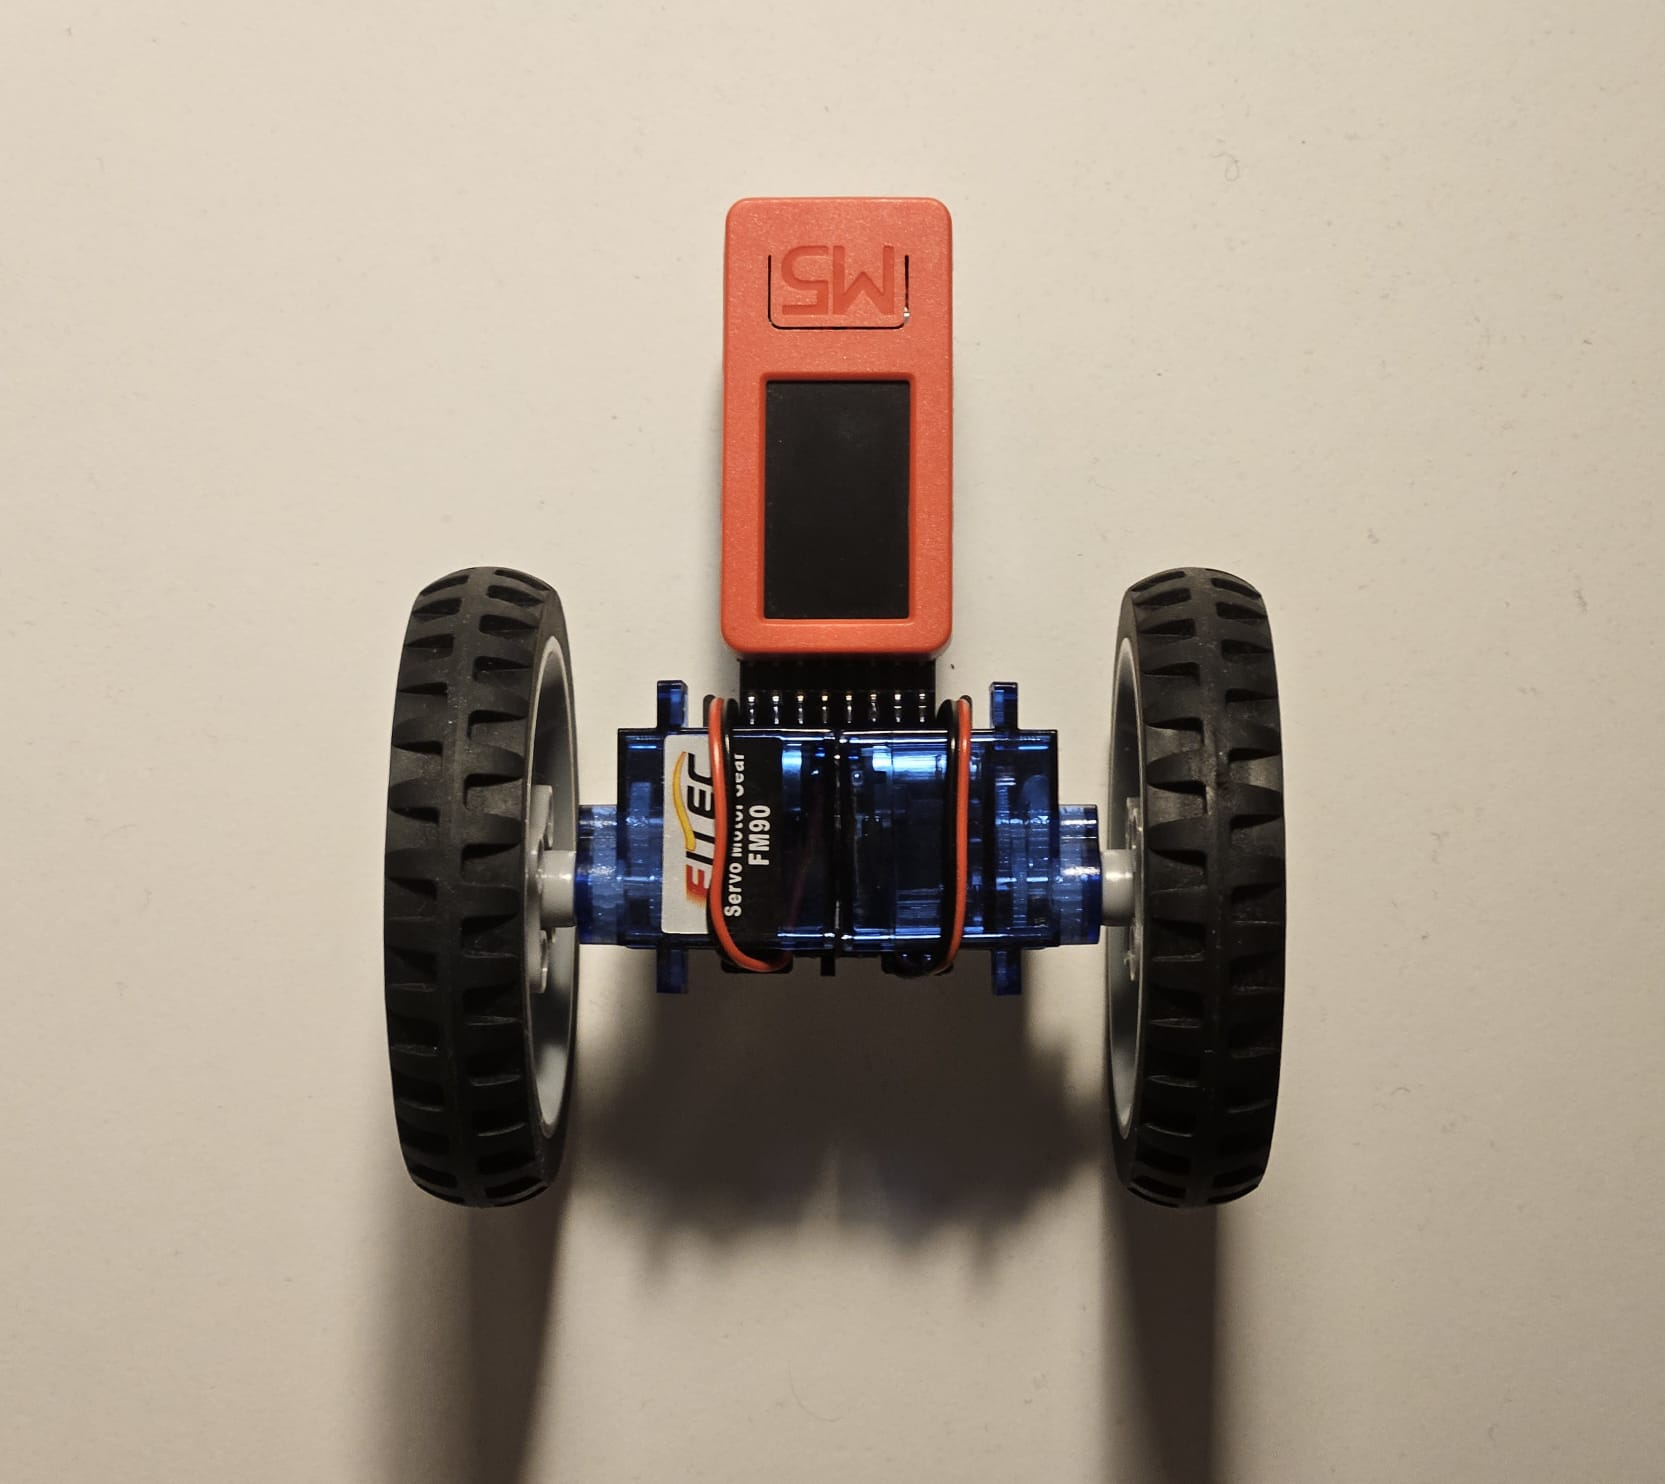

<div dir="rtl">

## דרישות מערכת וספריות
נדרשות הספריות הבאות להרצת הפרויקט:
</div>

In [ ]:
!pip install gymnasium
!pip install torchsummary

import gymnasium as gym
from gymnasium import spaces
import numpy as np
from typing import Tuple, Dict, Any
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from collections import deque
import random
from IPython.display import HTML, display
import os
import json
import shutil
import imageio_ffmpeg as ffmpeg

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = [10.0, 6.0]
matplotlib.use('Agg')
# Make matplotlib's outputs appear in the cell output sections
%matplotlib inline

<div dir="rtl">

# מודל פיזיקלי

## פרמטרים פיזיקליים
המערכת מדמה רובוט דו-גלגלי הפועל תחת חוקי הפיזיקה הבאים:

- **כוח הכבידה**: משפיע על מרכז המסה של הרובוט
- **חיכוך**: משפיע על תנועת הגלגלים
- **מומנט**: נוצר על ידי המנועים

## מבנה הרובוט
הרובוט מורכב מ:
- **גוף**: מוט קשיח עם מסה במרכז
- **שני גלגלים**: מחוברים לגוף באמצעות מנועים
- **חיישנים**: מודדים את זווית הגוף וקצב השינוי שלה

## מצבי המערכת
המערכת מתוארת על ידי שישה משתני מצב:
1. `theta`: זווית הגוף ביחס לאנך
2. `theta_dot`: קצב שינוי הזווית
3. `x`: מיקום אופקי
4. `x_dot`: מהירות אופקית
5. `phi`: זווית סיבוב הגלגלים
6. `phi_dot`: מהירות סיבוב הגלגלים

</div>

In [2]:
class PhysicsParams:
    """Physical parameters of the two-wheeled balancing robot."""
    def __init__(self):
        # Environmental constants
        self.g = 9.81  # Gravity (m/s²)

        # Robot body parameters
        self.M = 0.06   # Mass of the robot body (kg)
        self.m = 0.04   # Mass of each wheel (kg)
        self.l = 0.025  # Length to robot's center of mass (m)
        self.r = 0.033  # Wheel radius (m)
        self.I = 0.001  # Robot body moment of inertia
        self.i = 2e-5   # Wheel moment of inertia

        # Simulation parameters
        self.dt = 0.01  # Time step (s)

        # Motor parameters
        self.motor_deadzone = 0.04  # Minimum torque to overcome static friction

In [3]:
class TwoWheelBalancerEnv(gym.Env):
    """
    Gymnasium environment for a two-wheeled balancing robot.

    State space (6 dimensions):
        - theta: Angle from vertical (rad)
        - theta_dot: Angular velocity (rad/s)
        - x: Horizontal position (m)
        - x_dot: Horizontal velocity (m/s)
        - phi: Wheel angle (rad)
        - phi_dot: Wheel angular velocity (rad/s)

    Action space (1 dimension):
        - motor_torque: Applied motor torque (N⋅m)
    """

    def __init__(self):
        super(TwoWheelBalancerEnv, self).__init__()

        # Initialize physics parameters
        self.params = PhysicsParams()

        # Define action space (motor torque)
        self.max_torque = 0.23  # Maximum torque in N⋅m
        self.action_space = spaces.Box(
            low=(-1 * self.max_torque),
            high=(self.max_torque),
            shape=(1,),
            dtype=np.float32
        )

        # Define observation space
        obs_high = np.array([
            np.pi/2,    # theta
            8.0,        # theta_dot
            np.inf,     # x
            5.0,        # x_dot
            np.inf,     # phi
            20.0        # phi_dot
        ])
        self.observation_space = spaces.Box(
            low=(-1 * obs_high),
            high=(obs_high),
            dtype=np.float32
        )

        # Initialize state
        self.state = None
        self.static_friction_coeff = 0.7
        self.stable_duration = 0

    def reset(self, seed=None, options=None):
        """Reset the environment to initial state."""
        super().reset(seed=seed)

        # Initialize with small random angle
        self.state = np.array([
            np.random.uniform(-0.3, 0.3),  # theta
            0.0,                           # theta_dot
            np.random.uniform(-0.15, 0.15),# x
            0.0,                           # x_dot
            0.0,                           # phi
            0.0                            # phi_dot
        ])
        self.stable_duration = 0
        return self.state

    def apply_deadzone(self, torque: np.ndarray) -> np.ndarray:
        """Apply motor deadzone effect to torque."""
        if abs(torque.item()) < self.params.motor_deadzone:
            return np.zeros_like(torque)
        return torque

    def _get_acceleration(self, state: np.ndarray, torque: np.ndarray) -> np.ndarray:
        """
        Calculate system accelerations based on current state and applied torque.

        Returns:
            ndarray: [theta_ddot, x_ddot, phi_ddot]
        """
        theta, theta_dot = state[0], state[1]
        p = self.params

        # Calculate static friction effects
        normal_force = (p.M + 2*p.m) * p.g
        max_static_friction = self.static_friction_coeff * normal_force

        # If no torque, check static friction
        if abs(torque.item()) < p.motor_deadzone:
            required_friction = abs(p.M * p.g * p.l * np.sin(theta))

            if required_friction <= max_static_friction:
                # Static friction keeps system rigid
                I_total = p.M * p.l**2 + p.I + 2 * (p.m * p.r**2 + p.i)
                theta_ddot = (p.M * p.g * p.l * np.sin(theta)) / I_total
                x_ddot = p.r * theta_ddot
                phi_ddot = -theta_ddot
            else:
                # Static friction exceeded
                theta_ddot = (p.M * p.g * p.l * np.sin(theta)) / (p.M * p.l**2 + p.I)
                x_ddot = (-p.M * p.l * theta_ddot * np.cos(theta)) / (p.M + 2*p.m)
                phi_ddot = 0
        else:
            # Normal dynamics with applied torque
            effective_force = torque.item() / p.r
            theta_ddot = (p.M * p.g * p.l * np.sin(theta) - torque.item()) / (p.M * p.l**2 + p.I)
            x_ddot = (effective_force - p.M * p.l * theta_ddot * np.cos(theta)) / (p.M + 2*p.m)
            phi_ddot = torque.item() / p.i

        return np.array([theta_ddot, x_ddot, phi_ddot])

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, Dict[str, Any]]:
        """Execute one environment step."""
        action = np.clip(action, self.action_space.low, self.action_space.high)
        effective_torque = self.apply_deadzone(action)

        # Extract current state
        theta, theta_dot = self.state[0], self.state[1]
        x, x_dot = self.state[2], self.state[3]
        phi, phi_dot = self.state[4], self.state[5]

        # Calculate accelerations
        accel = self._get_acceleration(self.state, effective_torque)
        theta_ddot, x_ddot, phi_ddot = accel

        # Semi-implicit Euler integration
        dt = self.params.dt

        # Update velocities
        theta_dot += theta_ddot * dt
        x_dot += x_ddot * dt
        phi_dot += phi_ddot * dt

        # Update positions
        theta += theta_dot * dt
        x += x_dot * dt
        phi += phi_dot * dt

        # Update state
        self.state = np.array([theta, theta_dot, x, x_dot, phi, phi_dot])

        # Calculate reward components
        angle_reward = np.exp(-10.0 * abs(theta)**2)
        angular_vel_penalty = -0.5 * (theta_dot ** 2)
        position_reward = np.exp(-5.0 * x**2)
        velocity_reward = -0.1 * (x_dot ** 2)

        # Combine rewards
        reward = (2.0 * angle_reward +
                 3.0 * angular_vel_penalty +
                 5.0 * position_reward +
                 0.5 * velocity_reward)

        # Check termination conditions
        done_reasons = {
            'angle': bool(abs(theta) > np.pi/3),
            'position': bool(abs(x) > 0.5)
        }
        terminated = any(done_reasons.values())

        # Apply termination penalty
        if terminated:
            reward -= 400.0

        # Store reward components for analysis
        info = {
            'effective_torque': effective_torque,
            'reward_components': {
                'angle_reward': angle_reward,
                'angular_vel_penalty': angular_vel_penalty,
                'position_reward': position_reward,
                'velocity_reward': velocity_reward,
                'total_reward': reward
            },
            'stable_duration': self.stable_duration,
            'done_reasons': done_reasons,
        }

        return self.state, reward, terminated, False, info

    def render(self):
        """Render the current state."""
        if not hasattr(self, 'fig'):
            # Initialize figure
            self.fig = plt.figure(figsize=(10, 8))
            self.ax = plt.gca()
            self.title = self.ax.set_title('')
            self.ax.set_aspect('equal')

            # Create robot elements
            self.wheel = plt.Circle((0, 0), self.params.r, fill=False, color='black')
            self.body = plt.Line2D([], [], color='blue', linewidth=3)

            # Add elements to plot
            self.ax.add_patch(self.wheel)
            self.ax.add_line(self.body)

        # Extract state
        theta = self.state[0]
        x = self.state[2]

        # Update wheel position
        self.wheel.center = (x, self.params.r)

        # Update body position
        body_start = (x, self.params.r)
        body_end = (x + self.params.l * np.sin(theta),
                   self.params.r + self.params.l * np.cos(theta))
        self.body.set_data([body_start[0], body_end[0]],
                          [body_start[1], body_end[1]])

        # Update title and view
        self.title.set_text(f'θ: {theta * 180/np.pi:.1f}°, x: {x:.2f} m')
        self.ax.set_xlim(x - 0.3, x + 0.3)
        self.ax.set_ylim(-0.1, 0.2)
        self.ax.grid(True)

        # Draw
        self.fig.canvas.draw()
        plt.pause(0.001)

<div dir="rtl">

# הרצת בדיקה של הסביבה

באמצעות פעולות רנדומליות, נבדוק את תפקוד הסביבה

</div>

In [ ]:
def test_environment():
    """Test the environment with random actions and display basic info."""
    env = TwoWheelBalancerEnv()
    state = env.reset()

    # Print initial setup
    print("=== Environment Setup ===")
    print("Initial state:", state)
    print(f"  θ (angle): {state[0]*180/np.pi:.2f}°")
    print(f"  θ_dot (angular velocity): {state[1]:.2f} rad/s")
    print(f"  x (position): {state[2]:.2f} m")
    print(f"  x_dot (velocity): {state[3]:.2f} m/s")
    print(f"  φ (wheel angle): {state[4]:.2f} rad")
    print(f"  φ_dot (wheel velocity): {state[5]:.2f} rad/s")

    print("\nAction space:", env.action_space)
    print("  Type:", type(env.action_space))
    print("  Shape:", env.action_space.shape)
    print("  Bounds:", env.action_space.low[0], "to", env.action_space.high[0], "N⋅m")

    print("\nObservation space:", env.observation_space)
    print("  Type:", type(env.observation_space))
    print("  Shape:", env.observation_space.shape)

    print("\n=== Testing Random Actions ===")
    total_reward = 0

    # Test a few random actions
    for i in range(5):
        action = env.action_space.sample()
        state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward

        print(f"\nStep {i + 1}")
        print(f"Action (torque): {action[0]:.3f} N⋅m")
        print("State:")
        print(f"  θ: {state[0]*180/np.pi:.2f}°")
        print(f"  θ_dot: {state[1]:.2f} rad/s")
        print(f"  x: {state[2]:.2f} m")
        print(f"  x_dot: {state[3]:.2f} m/s")
        print(f"  φ: {state[4]:.2f} rad")
        print(f"  φ_dot: {state[5]:.2f} rad/s")
        print(f"Reward: {reward:.2f}")

        if terminated or truncated:
            print("Episode ended because:")
            if terminated:
                for reason, triggered in info['done_reasons'].items():
                    if triggered:
                        print(f"  - {reason}")

        # Render the environment
        env.render()
        plt.pause(0.1)

    print("\n=== Test Summary ===")
    print(f"Total reward: {total_reward:.2f}")
    print(f"Average reward per step: {total_reward/5:.2f}")

    # Close the rendering window
    plt.close()


test_environment()

<div dir="rtl">

# מודל Reinforcement Learning מסוג:

## DDPG - Deep Deterministic Policy Gradient
המערכת משתמשת באלגוריתם DDPG, שהוא שיטת למידת חיזוקים המתאימה במיוחד למערכות עם מרחב פעולות רציף.
(כמו מצערת המנועים)

### רכיבי המודל

1. **Actor Network**
   - רשת נוירונים המייצרת פעולות על סמך מצב המערכת
   - מבנה: Linear(6→8) → LayerNorm → ReLU → Linear(8→8) → LayerNorm → ReLU → Linear(8→1)

2. **Critic Network**
   - רשת נוירונים המעריכה את איכות הפעולות
   - מבנה: Linear(7→256) → LayerNorm → ReLU → Linear(256→256) → LayerNorm → ReLU → Linear(256→1)

3. **Replay Buffer**
   - מאגר זיכרון לשמירת חוויות הסוכן
   - משמש לאימון יציב יותר של הרשתות

### פרמטרי אימון
- גודל batch: 512
- קצב למידה: 1e-4 (Actor), 3e-4 (Critic)
- גורם דעיכה (γ): 0.99
- τ לעדכון רשתות המטרה: 0.005

</div>

In [5]:
class ReplayBuffer:
    """Experience replay buffer for storing and sampling transitions."""

    def __init__(self, capacity: int):
        """Initialize buffer with given capacity."""
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """Store a transition."""
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        """Sample a batch of transitions."""
        batch = random.sample(self.buffer, batch_size)
        return map(np.stack, zip(*batch))

    def __len__(self):
        return len(self.buffer)

In [6]:
class Actor(nn.Module):
    """Actor network for DDPG."""

    def __init__(self, state_dim: int, action_dim: int, max_action: float):
        super(Actor, self).__init__()
        self.max_action = max_action

        # Define network layers
        self.l1 = nn.Linear(state_dim, 8)
        self.ln1 = nn.LayerNorm(8)
        self.l2 = nn.Linear(8, 8)
        self.ln2 = nn.LayerNorm(8)
        self.l3 = nn.Linear(8, action_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        """Initialize network weights using orthogonal initialization."""
        if isinstance(m, nn.Linear):
            nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
            nn.init.constant_(m.bias, 0)

    def forward(self, state):
        """Forward pass through the network."""
        # override the positions and velocities, along with wheel angle off the state with zeroes
        a = F.relu(self.ln1(self.l1(state)))
        a = F.relu(self.ln2(self.l2(a)))
        return self.max_action * torch.tanh(self.l3(a))

In [7]:
class Critic(nn.Module):
    """Critic network for DDPG."""

    def __init__(self, state_dim: int, action_dim: int):
        super(Critic, self).__init__()

        # Define network layers
        self.l1 = nn.Linear(state_dim + action_dim, 256)
        self.ln1 = nn.LayerNorm(256)
        self.l2 = nn.Linear(256, 256)
        self.ln2 = nn.LayerNorm(256)
        self.l3 = nn.Linear(256, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        """Initialize network weights using orthogonal initialization."""
        if isinstance(m, nn.Linear):
            nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
            nn.init.constant_(m.bias, 0)

    def forward(self, state, action):
        """Forward pass through the network."""
        sa = torch.cat([state, action], 1)
        q = F.relu(self.ln1(self.l1(sa)))
        q = F.relu(self.ln2(self.l2(q)))
        return self.l3(q)

In [8]:
class DDPG:
    """Deep Deterministic Policy Gradient algorithm implementation."""

    def __init__(
        self,
        state_dim: int,
        action_dim: int,
        max_action: float,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
        actor_lr: float = 1e-4,
        critic_lr: float = 3e-4,
        gamma: float = 0.99,
        tau: float = 0.005,
        batch_size: int = 512,
        buffer_size: int = int(1e6)
    ):
        self.device = device
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.max_action = max_action
        self.state_dim = state_dim
        self.action_dim = action_dim

        # Initialize actor networks
        self.actor = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target = Actor(state_dim, action_dim, max_action).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

        # Initialize critic networks
        self.critic = Critic(state_dim, action_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)

        # Initialize replay buffer
        self.replay_buffer = ReplayBuffer(buffer_size)

        # Training parameters
        self.total_it = 0
        self.warmup_steps = 5000

    def select_action(self, state: np.ndarray, add_noise: bool = True) -> np.ndarray:
        """Select an action given the current state."""
        with torch.no_grad():
            state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
            action = self.actor(state).cpu().numpy().flatten()

            if add_noise:
                noise_scale = 1.0 if self.total_it < self.warmup_steps else 0.1
                noise = np.random.normal(0, noise_scale * self.max_action)
                action = action + noise

            return np.clip(action, -self.max_action, self.max_action)

    def train(self):
        """Perform one iteration of training on a batch from replay buffer."""
        self.total_it += 1

        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample from replay buffer
        state, action, reward, next_state, done = self.replay_buffer.sample(self.batch_size)

        # Convert to tensors
        state = torch.FloatTensor(state).to(self.device)
        action = torch.FloatTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.FloatTensor(done).to(self.device)

        # Compute target Q value
        target_Q = self.critic_target(next_state, self.actor_target(next_state))
        target_Q = reward.unsqueeze(1) + (1 - done.unsqueeze(1)) * self.gamma * target_Q

        # Compute current Q value
        current_Q = self.critic(state, action)

        # Compute critic loss and optimize
        critic_loss = F.mse_loss(current_Q, target_Q.detach())
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Delayed policy updates
        if self.total_it % 2 == 0:
            # Compute actor loss
            actor_loss = -self.critic(state, self.actor(state)).mean()

            # Optimize actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # Soft update target networks
            self._soft_update(self.actor_target, self.actor)
            self._soft_update(self.critic_target, self.critic)

    def print_model_info(self):
        """Print information about the model."""
        print("Actor Network:")
        print(summary(self.actor, input_size=(self.state_dim,)))
        print("\nCritic Network:")
        print(summary(self.critic, input_size=([(self.state_dim,), (self.action_dim,)])))

    def _soft_update(self, target: nn.Module, source: nn.Module):
        """Soft update target network parameters."""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    def save(self, path: str, verbose: bool = False):
        """Save model weights."""
        torch.save(self.actor.state_dict(), f"{path}_actor.pth")
        torch.save(self.critic.state_dict(), f"{path}_critic.pth")
        if verbose:
          print(f"Model saved to {path}")

    def load(self, path: str):
        """Load model weights."""
        self.actor.load_state_dict(torch.load(f"{path}_actor.pth", map_location=self.device))
        self.critic.load_state_dict(torch.load(f"{path}_critic.pth", map_location=self.device))
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())
        print("Model loaded successfully")

<div dir="rtl">

# אימון והערכת ביצועים

## תהליך האימון
האימון מתבצע במספר שלבים:
1. **אתחול**: יצירת הסביבה והסוכן עם הפרמטרים הנדרשים
2. **איסוף נתונים**: איסוף דגימות ראשוניות למאגר הזיכרון
3. **אימון**: אימון הרשתות על בסיס דגימות מהמאגר
4. **הערכה**: בדיקת ביצועי הסוכן במהלך האימון

## כלי הערכה
- **מדדי ביצוע**: מעקב אחר התגמול הממוצע ומשך האפיזודות
- **ויזואליזציה**: הצגת התקדמות האימון והתנהגות הרובוט
- **בדיקות יציבות**: מדידת יכולת האיזון לאורך זמן

</div>

In [9]:
def evaluate_policy(env, agent, num_episodes=5, max_steps=500, render=False):
    """
    Evaluate the agent's performance without exploration noise.

    Args:
        env: The environment
        agent: The trained agent
        num_episodes: Number of evaluation episodes
        max_steps: Maximum steps per episode
        render: Whether to render the environment

    Returns:
        float: Average reward across episodes
    """
    total_reward = 0

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        for step in range(max_steps):
            action = agent.select_action(state, add_noise=False)
            state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward

            if render:
                env.render()

            if terminated or truncated:
                break

        total_reward += episode_reward

    return total_reward / num_episodes

In [10]:
def train_agent(
    env,
    agent,
    num_episodes=2000,
    max_steps=500,
    stop_reward=2000,
    min_episodes=600,
    eval_freq=10,
    checkpoint_freq=100,
    save_prefix='checkpoints/balancer'
    ):
    """
    Train the DDPG agent in the balancing environment.

    Args:
        env: The balancing environment
        agent: The DDPG agent
        num_episodes: Total number of training episodes
        max_steps: Maximum steps per episode
        eval_freq: Frequency of evaluation during training
        checkpoint_freq: Frequency of saving checkpoints
        save_prefix: Prefix for saved model files

    Returns:
        dict: Training history including rewards and evaluations
    """
    os.makedirs('checkpoints', exist_ok=True)
    history = {
        'episode_rewards': [],
        'eval_rewards': [],
        'episode_lengths': [],
        'best_reward': float('-inf')
    }
    final_episode = num_episodes - 1

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0

        for step in range(max_steps):
            # Select action and add exploration noise
            action = agent.select_action(state, add_noise=True)

            # Take step in environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Store experience
            agent.replay_buffer.push(state, action, reward, next_state, done)

            # Update agent
            agent.train()

            episode_reward += reward
            state = next_state

            if done:
                break

        # Record episode statistics
        history['episode_rewards'].append(episode_reward)
        history['episode_lengths'].append(step + 1)

        # Periodic evaluation
        if (episode + 1) % eval_freq == 0:
            eval_reward = evaluate_policy(env, agent)
            history['eval_rewards'].append(eval_reward)

            print(f"Episode {episode + 1}: Train reward = {episode_reward:.2f}, "
                  f"Eval reward = {eval_reward:.2f}")

            # Save best model
            if eval_reward > history['best_reward']:
                history['best_reward'] = eval_reward
                agent.save(f"{save_prefix}_best")

        # Save periodic checkpoint
        if (episode + 1) % checkpoint_freq == 0:
            agent.save(f"{save_prefix}_episode_{episode + 1}")

        # Check for early stopping
        if episode_reward > stop_reward and episode > min_episodes:
            final_episode = episode
            print(f"Stopping training at episode {episode + 1} with reward {episode_reward:.2f}")
            break

    # Final save
    agent.save(f"{save_prefix}_final")
    return history

In [14]:
def plot_training_results(history):
    """
    Plot training progress including rewards and episode lengths.

    Args:
        history: Dictionary containing training history
    """

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

    # Plot rewards
    ax1.plot(history['episode_rewards'], label='Training', alpha=0.6)
    # eval_x = np.arange(0, len(history['episode_rewards']), 10)
    eval_x = np.arange(0, len(history['episode_rewards']), len(history['episode_rewards']) / len(history['eval_rewards']))
    ax1.plot(eval_x, history['eval_rewards'], label='Evaluation', linewidth=2)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title('Training and Evaluation Rewards')
    ax1.grid(True)
    ax1.legend()

    # Plot episode lengths
    ax2.plot(history['episode_lengths'])
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Steps')
    ax2.set_title('Episode Lengths')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def create_demo_animation(env, agent, max_steps=500, filename='balance_demo.mp4'):
    """
    Create an animation of the trained agent balancing.

    Args:
        env: The environment
        agent: The trained agent
        max_steps: Maximum steps to animate
        filename: Output filename for the animation

    Returns:
        HTML: IPython HTML object containing the animation
    """
    state = env.reset()
    trajectory = []

    # Collect trajectory
    for step in range(max_steps):
        action = agent.select_action(state, add_noise=False)
        next_state, reward, done, _, info = env.step(action)
        trajectory.append((state.copy(), action.copy()))
        if done:
            break
        state = next_state

    # Determine fixed view limits
    x_positions = [s[2] for s,_ in trajectory]
    x_min, x_max = min(x_positions), max(x_positions)
    view_width = max(x_max - x_min + 0.4, 1.0)  # Add padding
    x_center = (x_min + x_max) / 2

    # Create figure
    fig = plt.figure(figsize=(10, 8))
    ax = plt.gca()

    def animate(i):
        ax.clear()
        state, action = trajectory[i]

        # Draw robot
        wheel_x = state[2]
        wheel_y = env.params.r
        body_x = wheel_x + env.params.l * np.sin(state[0])
        body_y = wheel_y + env.params.l * np.cos(state[0])

        # Draw ground line
        ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)

        circle = plt.Circle((wheel_x, wheel_y), env.params.r, fill=False, color='black')
        ax.add_patch(circle)
        ax.plot([wheel_x, body_x], [wheel_y, body_y], 'b-', linewidth=3)

        plt.title(f'θ: {state[0]*180/np.pi:.1f}°, x: {state[2]:.2f}m\Torque: {action.item():.2f}')
        ax.set_xlim(x_center - view_width/2, x_center + view_width/2)
        ax.set_ylim(-0.1, 0.2)
        ax.grid(True)
        ax.set_aspect('equal')

    anim = animation.FuncAnimation(fig, animate, frames=len(trajectory), interval=20)
    writer = animation.FFMpegWriter(fps=30)
    anim.save(filename, writer=writer)
    plt.close()

    return HTML(f'<video src="{filename}" controls autoplay loop></video>')

<div dir="rtl">

# הרצת האימון והדגמה

## שלבי ההרצה
1. **הכנה**: יצירת הסביבה והסוכן עם הפרמטרים האופטימליים
2. **אימון**: הרצת תהליך האימון המלא
3. **הדגמה**: יצירת הדמיה של הרובוט המאוזן
4. **שמירה**: שמירת המודל המאומן לשימוש עתידי

## פרמטרים נבחרים
- אורך אימון: 2000 אפיזודות
- צעדים מקסימליים: 500 לאפיזודה
- ערך החזר לסיום האימון: 2000
- כמות ניסויים מינימלית: 600 (גם בהגעה לערך העצירה נמשיך עד ערך זה)
- תדירות הערכה: כל 10 אפיזודות
- תדירות שמירה: כל 100 אפיזודות

</div>

In [15]:
# Set random seeds for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
# Set seeds for reproducibility
set_seeds()

# Create environment
env = TwoWheelBalancerEnv()

# Get dimensions
state_dim = env.observation_space.shape[0]  # 6
action_dim = 1  # Single torque output
max_action = float(env.action_space.high[0])

# Create DDPG agent
agent = DDPG(
    state_dim=state_dim,
    action_dim=action_dim,
    max_action=max_action,
    actor_lr=1e-4,
    critic_lr=3e-4,
    buffer_size=int(1e6),
    batch_size=512
)

agent.print_model_info()

# Training parameters
train_params = {
    'num_episodes': 50,
    'max_steps': 500,
    'stop_reward': 2000,
    'min_episodes': 700,
    'eval_freq': 10,
    'checkpoint_freq': 100,
    'save_prefix': 'checkpoints/balancer'
}

print("Starting training...")
history = train_agent(env, agent, **train_params)

# Plot training results
plot_training_results(history)

print("\nCreating demonstration video...")
demo = create_demo_animation(env, agent)

# Final evaluation
print("\nFinal evaluation:")
final_reward = evaluate_policy(env, agent, num_episodes=10, render=False)
print(f"Average reward over 10 episodes: {final_reward:.2f}")

In [ ]:
# Reload the model after training. Can be ran from here with an upladed trained agent
agent = DDPG(
    state_dim=state_dim,
    action_dim=action_dim,
    max_action=max_action
)
agent.load('checkpoints/balancer_best')

<div dir="rtl">

# ניתוח ביצועים וויזואליזציה

## סוגי הויזואליזציות
1. **גרפי אימון**: הצגת התקדמות האימון של הרשת
2. **ניתוח מסלול**: הצגת המסלולים שהרובוט עובר
3. **מדדי ביצוע**: ניתוח מפורט של יציבות הרובוט

## מדדים מרכזיים
- זווית מקסימלית
- זמן איזון רציף
- טווח תנועה
- צריכת אנרגיה (מומנט מנועים)

## הצגת נתונים
- גרפים אינטראקטיביים
- הדמיית וידאו
- טבלאות ביצועים

</div>

In [16]:
def analyze_performance(env, agent, num_episodes=10, max_steps=500):
    """
    Analyze the agent's performance across multiple episodes.

    Args:
        env: The balancing environment
        agent: The trained agent
        num_episodes: Number of episodes to analyze
        max_steps: Maximum steps per episode

    Returns:
        dict: Performance metrics and trajectory data
    """
    metrics = {
        'max_angles': [],
        'balance_times': [],
        'position_ranges': [],
        'average_torque': [],
        'trajectories': []
    }

    for episode in range(num_episodes):
        state = env.reset()
        episode_data = {
            'angles': [],
            'positions': [],
            'torques': [],
            'velocities': []
        }

        for step in range(max_steps):
            # Record state
            angle = state[0]
            position = state[2]
            velocity = state[3]

            # Get action
            action = agent.select_action(state, add_noise=False)
            episode_data['angles'].append(angle * 180/np.pi)  # Convert to degrees
            episode_data['positions'].append(position)
            episode_data['torques'].append(action[0])
            episode_data['velocities'].append(velocity)

            # Take step
            state, _, terminated, _, _ = env.step(action)
            if terminated:
                break

        # Calculate episode metrics
        metrics['max_angles'].append(max(abs(np.array(episode_data['angles']))))
        metrics['balance_times'].append(step + 1)
        metrics['position_ranges'].append(
            max(episode_data['positions']) - min(episode_data['positions']))
        metrics['average_torque'].append(
            np.mean(abs(np.array(episode_data['torques']))))
        metrics['trajectories'].append(episode_data)

    return metrics

def plot_performance_metrics(metrics):
    """
    Create detailed performance visualization plots.

    Args:
        metrics: Dictionary containing performance metrics
    """
    fig = plt.figure(figsize=(15, 10))

    # Plot balance times
    plt.subplot(221)
    plt.boxplot(metrics['balance_times'])
    plt.title('Balance Duration')
    plt.ylabel('Steps')
    plt.grid(True)

    # Plot max angles
    plt.subplot(222)
    plt.boxplot(metrics['max_angles'])
    plt.title('Maximum Angle Deviation')
    plt.ylabel('Degrees')
    plt.grid(True)

    # Plot position ranges
    plt.subplot(223)
    plt.boxplot(metrics['position_ranges'])
    plt.title('Position Range')
    plt.ylabel('Meters')
    plt.grid(True)

    # Plot average torque
    plt.subplot(224)
    plt.boxplot(metrics['average_torque'])
    plt.title('Average Motor Torque')
    plt.ylabel('N⋅m')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_episode_trajectory(trajectory_data):
    """
    Plot detailed trajectory data from a single episode.

    Args:
        trajectory_data: Dictionary containing episode trajectory data
    """
    fig = plt.figure(figsize=(15, 10))
    time = np.arange(len(trajectory_data['angles']))

    # Plot angle over time
    plt.subplot(311)
    plt.plot(time, trajectory_data['angles'])
    plt.title('Angle vs Time')
    plt.ylabel('Angle (degrees)')
    plt.grid(True)

    # Plot position and velocity
    plt.subplot(312)
    plt.plot(time, trajectory_data['positions'], label='Position')
    plt.plot(time, trajectory_data['velocities'], label='Velocity')
    plt.title('Position and Velocity vs Time')
    plt.ylabel('Meters / Meters per Second')
    plt.legend()
    plt.grid(True)

    # Plot motor torque
    plt.subplot(313)
    plt.plot(time, trajectory_data['torques'])
    plt.title('Motor Torque vs Time')
    plt.xlabel('Time Step')
    plt.ylabel('Torque (N⋅m)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def generate_performance_report(env, agent, filename='performance_report.html'):
    """
    Generate a comprehensive performance report.

    Args:
        env: The balancing environment
        agent: The trained agent
        filename: Output HTML file name
    """
    # Analyze performance
    metrics = analyze_performance(env, agent)

    # Calculate summary statistics
    summary = {
        'avg_balance_time': np.mean(metrics['balance_times']),
        'max_angle': np.mean(metrics['max_angles']),
        'avg_position_range': np.mean(metrics['position_ranges']),
        'avg_torque': np.mean(metrics['average_torque']),
        'success_rate': sum(t >= 500 for t in metrics['balance_times']) / len(metrics['balance_times'])
    }

    # Generate report
    report = f"""
    <html>
    <head>
        <title>Balance Robot Performance Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 40px; }}
            table {{ border-collapse: collapse; width: 60%; }}
            th, td {{ padding: 12px; text-align: left; border: 1px solid #ddd; }}
            th {{ background-color: #4CAF50; color: white; }}
            .metric {{ font-weight: bold; }}
        </style>
    </head>
    <body>
        <h1>Balance Robot Performance Report</h1>

        <h2>Performance Metrics</h2>
        <table>
            <tr>
                <th>Metric</th>
                <th>Value</th>
            </tr>
            <tr>
                <td>Average Balance Time</td>
                <td>{summary['avg_balance_time']:.2f} steps</td>
            </tr>
            <tr>
                <td>Average Max Angle</td>
                <td>{summary['max_angle']:.2f}°</td>
            </tr>
            <tr>
                <td>Average Position Range</td>
                <td>{summary['avg_position_range']:.3f} m</td>
            </tr>
            <tr>
                <td>Average Motor Torque</td>
                <td>{summary['avg_torque']:.3f} N⋅m</td>
            </tr>
            <tr>
                <td>Success Rate</td>
                <td>{summary['success_rate']*100:.1f}%</td>
            </tr>
        </table>
    </body>
    </html>
    """

    # Save report
    with open(filename, 'w') as f:
        f.write(report)

    return summary

In [ ]:
def run_analysis():
    """Run complete performance analysis of the balancing robot."""

    print("Loading environment and agent...")
    env = TwoWheelBalancerEnv()

    # Load a pre-trained agent
    state_dim = env.observation_space.shape[0]
    action_dim = 1
    max_action = float(env.action_space.high[0])

    agent = DDPG(
        state_dim=state_dim,
        action_dim=action_dim,
        max_action=max_action
    )
    agent.load('checkpoints/balancer_best')

    print("\nAnalyzing performance...")
    metrics = analyze_performance(env, agent, num_episodes=20)

    # Print summary statistics
    print("\nPerformance Summary:")
    print(f"Average balance time: {np.mean(metrics['balance_times']):.1f} steps")
    print(f"Maximum angle deviation: {np.mean(metrics['max_angles']):.2f}°")
    print(f"Average position range: {np.mean(metrics['position_ranges']):.3f} m")
    print(f"Average motor torque: {np.mean(metrics['average_torque']):.3f} N⋅m")

    # Create visualizations
    print("\nGenerating visualizations...")

    # Plot overall metrics
    print("Plotting performance metrics...")
    plot_performance_metrics(metrics)

    # Plot detailed trajectory
    print("Plotting example trajectory...")
    best_episode = np.argmax(metrics['balance_times'])
    plot_episode_trajectory(metrics['trajectories'][best_episode])

    # Generate phase space plot
    plt.figure(figsize=(10, 6))
    trajectory = metrics['trajectories'][best_episode]

    # Create energy analysis
    plt.figure(figsize=(10, 6))
    energy = np.array(trajectory['torques']) * np.array(trajectory['velocities'])
    plt.plot(np.cumsum(np.abs(energy)))
    plt.title('Cumulative Energy Usage')
    plt.xlabel('Time Step')
    plt.ylabel('Energy (J)')
    plt.grid(True)
    plt.show()

    # Generate and display animation
    print("\nCreating animation of best episode...")
    demo = create_demo_animation(env, agent, max_steps=len(trajectory['angles']),
                               filename='best_balance.mp4')

    return metrics, demo

def analyze_failure_modes(env, agent, num_episodes=50):
    """Analyze common failure modes of the balancing robot."""
    failure_stats = {
        'angle_exceeded': 0,
        'position_exceeded': 0,
        'average_failure_time': 0,
        'failure_angles': [],
        'failure_positions': []
    }

    for episode in range(num_episodes):
        state = env.reset()

        for step in range(500):
            action = agent.select_action(state, add_noise=False)
            next_state, _, terminated, _, info = env.step(action)

            if terminated:
                failure_stats['average_failure_time'] += step
                failure_stats['failure_angles'].append(state[0] * 180/np.pi)
                failure_stats['failure_positions'].append(state[2])

                if info['done_reasons']['angle']:
                    failure_stats['angle_exceeded'] += 1
                if info['done_reasons']['position']:
                    failure_stats['position_exceeded'] += 1
                break

            state = next_state

    # Calculate averages
    failure_stats['average_failure_time'] /= num_episodes

    # Plot failure analysis
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.pie([failure_stats['angle_exceeded'], failure_stats['position_exceeded']],
            labels=['Angle', 'Position'], autopct='%1.1f%%')
    plt.title('Failure Mode Distribution')

    plt.subplot(132)
    plt.hist(failure_stats['failure_angles'], bins=20)
    plt.title('Failure Angles')
    plt.xlabel('Angle (degrees)')

    plt.subplot(133)
    plt.hist(failure_stats['failure_positions'], bins=20)
    plt.title('Failure Positions')
    plt.xlabel('Position (m)')

    plt.tight_layout()
    plt.show()

    return failure_stats

# Example usage
print("Running performance analysis...")
metrics, demo = run_analysis()

print("\nGenerating performance report...")
summary = generate_performance_report(env, agent)

print("\nAnalysis complete! Check the generated visualizations and reports.")

<div dir="rtl">

# שליחת משקולות המודל אל הרובוט על גבי חיבור UDP

לשימוש יש להפעיל את הקוד בתא השני, ממחשב מקומי (לא בקולאב)

</div>

In [30]:
import os
import numpy as np
import json
import struct
import socket
import time


def export_network_weights(network, filename):
    """Export network weights and LayerNorm parameters to a binary file."""
    with open(filename, 'wb') as f:
        # L1 layer (32x6)
        weights = network.l1.weight.data.cpu().numpy()
        bias = network.l1.bias.data.cpu().numpy()

        # Write L1 shape (32x6)
        f.write(struct.pack('II', 8, 6))
        # Write L1 weights and bias
        f.write(weights.astype('float32').tobytes())
        f.write(bias.astype('float32').tobytes())
        # Write L1 LayerNorm parameters
        f.write(network.ln1.weight.data.cpu().numpy().astype('float32').tobytes())
        f.write(network.ln1.bias.data.cpu().numpy().astype('float32').tobytes())

        # L2 layer (32x32)
        weights = network.l2.weight.data.cpu().numpy()
        bias = network.l2.bias.data.cpu().numpy()

        # Write L2 shape (32x32)
        f.write(struct.pack('II', 8, 8))
        # Write L2 weights and bias
        f.write(weights.astype('float32').tobytes())
        f.write(bias.astype('float32').tobytes())
        # Write L2 LayerNorm parameters
        f.write(network.ln2.weight.data.cpu().numpy().astype('float32').tobytes())
        f.write(network.ln2.bias.data.cpu().numpy().astype('float32').tobytes())

        # L3 layer (1x32)
        weights = network.l3.weight.data.cpu().numpy()
        bias = network.l3.bias.data.cpu().numpy()

        # Write L3 shape (1x32)
        f.write(struct.pack('II', 1, 8))
        # Write L3 weights and bias
        f.write(weights.astype('float32').tobytes())
        f.write(bias.astype('float32').tobytes())

def verify_exported_weights(filename):
    """Verify that the weights were exported correctly."""
    with open(filename, 'rb') as f:
        print("\nVerifying weight file...")

        # L1 verification
        rows, cols = struct.unpack('II', f.read(8))
        print(f"L1 shape: {rows}x{cols}")  # Should be 32x6
        weights_size = rows * cols * 4
        bias_size = rows * 4
        norm_size = rows * 4
        f.seek(weights_size + bias_size + 2*norm_size, 1)
        print(f"Skipped {weights_size} bytes of weights")
        print(f"Skipped {bias_size} bytes of bias")
        print(f"Skipped {2*norm_size} bytes of LayerNorm parameters")

        # L2 verification
        rows, cols = struct.unpack('II', f.read(8))
        print(f"\nL2 shape: {rows}x{cols}")  # Should be 32x32
        weights_size = rows * cols * 4
        bias_size = rows * 4
        norm_size = rows * 4
        f.seek(weights_size + bias_size + 2*norm_size, 1)
        print(f"Skipped {weights_size} bytes of weights")
        print(f"Skipped {bias_size} bytes of bias")
        print(f"Skipped {2*norm_size} bytes of LayerNorm parameters")

        # L3 verification
        rows, cols = struct.unpack('II', f.read(8))
        print(f"\nL3 shape: {rows}x{cols}")  # Should be 1x32
        weights_size = rows * cols * 4
        bias_size = rows * 4
        f.seek(weights_size + bias_size, 1)
        print(f"Skipped {weights_size} bytes of weights")
        print(f"Skipped {bias_size} bytes of bias")

        # Calculate total file size
        total_size = f.tell()
        print(f"\nTotal file size: {total_size} bytes")

def export_agent_weights(agent, actor_file='actor_weights.bin', critic_file='critic_weights.bin'):
    """Export both actor and critic networks."""
    print("Exporting actor weights...")
    export_network_weights(agent.actor, actor_file)
    print("Verifying actor weights...")
    verify_exported_weights(actor_file)

    print("\nExporting critic weights...")
    export_network_weights(agent.critic, critic_file)
    print("Verifying critic weights...")
    verify_exported_weights(critic_file)


def send_weights_udp(filename, udp_ip="192.168.1.255", udp_port=44445):
        """Send network weights over UDP."""
        import socket

        # Create UDP socket
        sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        sock.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)

        # Read weights file
        with open(filename, 'rb') as f:
            data = f.read()

        # Split into chunks (UDP packet size limit is around 65507 bytes)
        chunk_size = 1024
        chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

        # Send number of chunks first
        sock.sendto(struct.pack('I', len(chunks)), (udp_ip, udp_port))

        # Send each chunk
        for i, chunk in enumerate(chunks):
            packet = struct.pack('I', i) + chunk
            sock.sendto(packet, (udp_ip, udp_port))

        sock.close()
        print(f"Sent {len(chunks)} chunks over UDP to {udp_ip}:{udp_port}")

In [ ]:
# Uncomment to export weights and transmit to the robot over UDP
# export_network_weights(agent.actor, 'actor_weights.bin')
# verify_exported_weights('actor_weights.bin')
# send_weights_udp('actor_weights.bin')

<div dir=rtl>

# ויזואליזציה של התקדמות האימון

מרכיב זה מאפשר יצירת סרטון המציג את התקדמות האימון של הרובוט. הסרטון מציג את השיפור ההדרגתי בביצועי הסוכן לאורך האימון, תוך שימוש במודלים שנשמרו בנקודות ציון שונות.


## פרמטרים לכיוון
- `episodes_to_show`: מספר האפיזודות לכלול בסרטון
- `max_steps`: מספר הצעדים המקסימלי לכל אפיזודה
- `speedup_factor`: מקדם האצה מקסימלי לאפיזודות מוקדמות
- `fps`: קצב הפריימים לשנייה בסרטון התוצאה


</div>

In [34]:
def create_training_progress_video(env, agent, checkpoints_dir='checkpoints', base_name='balancer_episode_',
                               output_file='training_progress.mp4', max_steps=500, episodes_to_show=10,
                               attempts_per_episode=3, speedup_factor=4, fps=30):
    import os
    import matplotlib.pyplot as plt
    from matplotlib import animation
    import numpy as np
    from tqdm import tqdm

    checkpoint_files = [f for f in os.listdir(checkpoints_dir)
                       if f.startswith(base_name) and f.endswith('_actor.pth')]
    episode_numbers = sorted([int(f.split('_')[-2]) for f in checkpoint_files])

    if len(episode_numbers) > episodes_to_show:
        indices = np.linspace(0, len(episode_numbers)-1, episodes_to_show, dtype=int)
        episode_numbers = [episode_numbers[i] for i in indices]

    fig, ax = plt.subplots(figsize=(12, 8))
    plt.grid(True)

    def get_speedup(episode_num, max_episode):
        progress = episode_num / max_episode
        return max(1, int(speedup_factor * (1 - progress**2)))

    all_trajectories = []
    max_episode = max(episode_numbers)

    for episode_num in episode_numbers:
        checkpoint_path = os.path.join(checkpoints_dir, f"{base_name}{episode_num}")
        agent.actor.load_state_dict(torch.load(f"{checkpoint_path}_actor.pth", weights_only=True))
        agent.critic.load_state_dict(torch.load(f"{checkpoint_path}_critic.pth", weights_only=True))

        episode_trajectories = []
        for attempt in range(attempts_per_episode):
            state = env.reset()
            episode_reward = 0
            trajectory = []
            noise_scale = 1.0 if attempt < attempts_per_episode - 1 else 0.0

            for step in range(max_steps):
                action = agent.select_action(state, add_noise=noise_scale > 0)
                if noise_scale > 0:
                    action = action + np.random.normal(0, 0.1, size=action.shape) * noise_scale
                next_state, reward, terminated, _, _ = env.step(action)
                episode_reward += reward
                trajectory.append((state.copy(), action.copy(), episode_reward))
                if terminated:
                    break
                state = next_state

            episode_trajectories.append(trajectory)

        current_speedup = get_speedup(episode_num, max_episode)
        all_trajectories.append({
            'trajectories': episode_trajectories,
            'episode_num': episode_num,
            'speedup': current_speedup
        })

    all_x_positions = []
    for ep in all_trajectories:
        for traj in ep['trajectories']:
            all_x_positions.extend([s[2] for s, _, _ in traj])
    x_min, x_max = min(all_x_positions), max(all_x_positions)
    view_width = max(x_max - x_min + 0.4, 1.0)
    x_center = (x_min + x_max) / 2

    # Create wheels and bodies with fixed alpha
    wheel = plt.Circle((0, 0), env.params.r, fill=False, color='black', alpha=1.0)
    ax.add_patch(wheel)
    body, = ax.plot([], [], 'b-', linewidth=3, alpha=1.0)
    wheels = [wheel]
    bodies = [[body]]

    # Add transparent wheels and bodies for attempts
    for i in range(attempts_per_episode - 1):
        wheel = plt.Circle((0, 0), env.params.r, fill=False, color='black', alpha=0.3)
        ax.add_patch(wheel)
        body, = ax.plot([], [], '-', color='blue', alpha=0.3, linewidth=3)
        wheels.append(wheel)
        bodies.append([body])

    speed_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, fontsize=10,
                        verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5',
                                                         facecolor='white', alpha=0.7))

    def init():
        ax.set_xlim(x_center - view_width/2, x_center + view_width/2)
        ax.set_ylim(-0.1, 0.2)
        ax.grid(True)
        ax.set_aspect('equal')
        return [wheel for wheel in wheels] + [line for body_lines in bodies for line in body_lines] + [speed_text]

    def animate(frame_idx):
        total_frames = 0
        current_episode = None

        for episode_data in all_trajectories:
            frames_in_episode = min(max(len(traj) for traj in episode_data['trajectories']), max_steps) // episode_data['speedup']
            if frame_idx < total_frames + frames_in_episode:
                current_episode = episode_data
                step_idx = (frame_idx - total_frames) * episode_data['speedup']
                break
            total_frames += frames_in_episode

        if current_episode is None:
            return [wheel for wheel in wheels] + [line for body_lines in bodies for line in body_lines] + [speed_text]

        # Update all attempts
        artists = []
        for attempt_idx, (wheel, body_lines) in enumerate(zip(wheels, bodies)):
            if step_idx >= len(current_episode['trajectories'][attempt_idx]):
                wheel.center = (1000, 0)  # remove from frame
                for line in body_lines:
                    line.set_data([], [])
                artists.extend([wheel] + body_lines)
                continue

            state, action, cum_reward = current_episode['trajectories'][attempt_idx][step_idx]

            wheel_x = state[2]
            wheel_y = env.params.r
            body_x = wheel_x + 2 * env.params.l * np.sin(state[0])
            body_y = wheel_y + 2 * env.params.l * np.cos(state[0])

            wheel.center = (wheel_x, wheel_y)
            artists.append(wheel)

            if attempt_idx < attempts_per_episode - 1:
                for i, line in enumerate(body_lines):
                    line.set_data([wheel_x, body_x], [wheel_y, body_y])
                    artists.append(line)
            else:
                body_lines[0].set_data([wheel_x, body_x], [wheel_y, body_y])
                artists.extend(body_lines)

        # Use data from the main (last) attempt for display
        valid_idx = min(step_idx, len(current_episode['trajectories'][-1]) - 1)
        main_state, _, main_reward = current_episode['trajectories'][-1][valid_idx]
        plt.title(f'Training Progress - Episode {current_episode["episode_num"]}/{max_episode}\n' +
                 f'θ: {main_state[0]*180/np.pi:.1f}°, x: {main_state[2]:.2f}m, ' +
                 f'Reward: {int(main_reward)}',
                 fontsize=12, pad=10)

        if current_episode['speedup'] > 1:
            speed_text.set_text(f'{current_episode["speedup"]}x speed')
            speed_text.set_visible(True)
        else:
            speed_text.set_visible(False)
        artists.append(speed_text)

        return artists

    # Calculate total frames
    total_frames = sum(max(len(traj) for traj in ep['trajectories']) // ep['speedup']
                      for ep in all_trajectories)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=total_frames, interval=1000/fps,
                                 blit=True)

    # Create progress bar
    progress_bar = tqdm(total=total_frames, desc='Generating video', position=0, leave=True)

    def progress_callback(current_frame, total_frames):
        progress_bar.update(1)

    writer = animation.FFMpegWriter(fps=fps, bitrate=2000)
    anim.save(output_file, writer=writer, progress_callback=progress_callback)

    progress_bar.close()
    plt.close()

    return f"\nVideo saved to {output_file} ({total_frames} frames)"

In [ ]:
# Create video of training progress
result = create_training_progress_video(
    env=env,
    agent=agent,
    checkpoints_dir='checkpoints',
    base_name='balancer_episode_',
    output_file='training_progress.mp4',
    max_steps=500,
    episodes_to_show=3,  # Number of episodes to include
    speedup_factor=1,     # Maximum speedup for early episodes
    fps=30,                # Output video framerate
    attempts_per_episode=20

)
print(result)

<div dir=rtl>

# כיוון עדין של מודל DDPG באמצעות נתונים מהרובוט האמיתי

## סקירה כללית
לאחר אימון ראשוני בסימולטור, המודל דורש כיוון עדין על בסיס נתונים אמיתיים מהרובוט. התהליך מתבצע במספר שלבים:

1. איסוף נתונים מהרובוט באמצעות UDP Logger
2. טעינת הנתונים למאגר זיכרון
3. אימון Offline DDPG

## אימון Offline DDPG
האלגוריתם כולל שני שיפורים עיקריים:
- רגולריזציה על ידי הוספת רעש לפעולות
- שילוב של behavior cloning לשמירה על התנהגות טובה


## טיפול בבעיות נפוצות
- **אובדן יציבות**: הקטנת קצב הלמידה
- **התכנסות איטית**: הגדלת מספר העדכונים
- **ביצועים גרועים**: בדיקת איכות נתוני האימון

</div>

In [ ]:
from dataclasses import dataclass

@dataclass
class Episode:
    states: np.ndarray  # [theta, theta_dot, x, x_dot, phi, phi_dot]
    actions: np.ndarray  # [motor_pwm]
    timestamps: np.ndarray
    metadata: Dict

def calculate_rewards(episode: Episode) -> np.ndarray:
    """Calculate rewards for each timestep in episode."""
    states = episode.states
    actions = episode.actions

    # Calculate reward components
    angle_reward = np.exp(-10.0 * abs(states[:, 0])**2)
    angular_vel_penalty = -0.5 * (states[:, 1] ** 2)
    position_reward = np.exp(-5.0 * states[:, 2]**2)
    velocity_reward = -0.1 * (states[:, 3] ** 2)

    # Combine rewards
    return (2.0 * angle_reward +
              3.0 * angular_vel_penalty +
              5.0 * position_reward +
              0.5 * velocity_reward)

In [ ]:
def load_real_world_data(filename: str) -> ReplayBuffer:
    """Load real-world data into replay buffer."""
    buffer = ReplayBuffer(int(1e6))

    with open(filename, 'r') as f:
        data = json.load(f)

    for episode_data in data['episodes']:
        states = np.array(episode_data['states'])
        actions = np.array(episode_data['actions'])
        rewards = calculate_rewards(Episode(
            states=states,
            actions=actions,
            timestamps=np.array(episode_data['timestamps']),
            metadata=episode_data['metadata']
        ))

        for t in range(len(states) - 1):
            buffer.push(
                states[t],
                actions[t],
                rewards[t],
                states[t + 1],
                False
            )

    return buffer

In [ ]:
class OfflineDDPG(DDPG):
    """Extended DDPG for offline fine-tuning."""

    def offline_update(self, buffer: ReplayBuffer, batch_size: int = 128):
        if len(buffer) < batch_size:
            return

        # Sample from replay buffer
        state, action, reward, next_state, done = buffer.sample(batch_size)

        # Convert to tensors
        state = torch.FloatTensor(state).to(self.device)
        action = torch.FloatTensor(action).to(self.device)
        reward = torch.FloatTensor(reward).to(self.device)
        next_state = torch.FloatTensor(next_state).to(self.device)
        done = torch.FloatTensor(done).to(self.device)

        # Add noise to next actions for regularization
        noise = torch.randn_like(action) * 0.1
        next_action = self.actor_target(next_state) + noise
        next_action = next_action.clamp(-self.max_action, self.max_action)

        # Compute target Q value
        target_Q = self.critic_target(next_state, next_action)
        target_Q = reward.unsqueeze(1) + (1 - done.unsqueeze(1)) * self.gamma * target_Q

        # Update Critic
        current_Q = self.critic(state, action)
        critic_loss = F.mse_loss(current_Q, target_Q.detach())
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update Actor (with conservative loss)
        actor_loss = -self.critic(state, self.actor(state)).mean()
        actor_loss += 0.1 * F.mse_loss(self.actor(state), action)  # Behavior cloning

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target networks
        self._soft_update(self.actor_target, self.actor)
        self._soft_update(self.critic_target, self.critic)

        return {
            'critic_loss': critic_loss.item(),
            'actor_loss': actor_loss.item()
        }

    @classmethod
    def from_ddpg(cls, agent: DDPG):
        """Convert regular DDPG to OfflineDDPG."""
        offline_agent = cls(
            state_dim=agent.state_dim,
            action_dim=agent.action_dim,
            max_action=agent.max_action,
            device=agent.device
        )

        # Copy weights manually
        offline_agent.actor.load_state_dict(agent.actor.state_dict())
        offline_agent.actor_target.load_state_dict(agent.actor_target.state_dict())
        offline_agent.critic.load_state_dict(agent.critic.state_dict())
        offline_agent.critic_target.load_state_dict(agent.critic_target.state_dict())

        return offline_agent

In [ ]:
def fine_tune_agent(
    agent: DDPG,
    log_file: str,
    num_updates: int = 10000,
    batch_size: int = 128,
    eval_freq: int = 100
):
    """Fine-tune pre-trained agent on real-world data."""

    # Convert DDPG to OfflineDDPG
    if not isinstance(agent, OfflineDDPG):
        agent = OfflineDDPG.from_ddpg(agent)

    # Load real-world data
    buffer = load_real_world_data(log_file)
    print(f"Loaded {len(buffer)} transitions from {log_file}")

    # Fine-tuning loop
    losses = []
    for i in range(num_updates):
        loss = agent.offline_update(buffer, batch_size)
        losses.append(loss)

        if (i + 1) % eval_freq == 0:
            print(f"Update {i+1}/{num_updates}")
            print(f"Critic Loss: {loss['critic_loss']:.3f}")
            print(f"Actor Loss: {loss['actor_loss']:.3f}")

    return losses

In [ ]:
def deploy_model_to_robot(agent, udp_ip="192.168.1.255", udp_port=44445):
    """Deploy fine-tuned model to robot via UDP."""
    # Export network weights
    weights_file = 'actor_weights_finetuned.bin'
    export_network_weights(agent.actor, weights_file)
    verify_exported_weights(weights_file)

    # Create UDP socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.setsockopt(socket.SOL_SOCKET, socket.SO_BROADCAST, 1)

    # Read weights file
    with open(weights_file, 'rb') as f:
        data = f.read()

    # Split into chunks
    chunk_size = 1024
    chunks = [data[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

    # Send number of chunks first
    sock.sendto(struct.pack('I', len(chunks)), (udp_ip, udp_port))
    print(f"Sending {len(chunks)} chunks...")

    # Send each chunk with index
    for i, chunk in enumerate(chunks):
        packet = struct.pack('I', i) + chunk
        sock.sendto(packet, (udp_ip, udp_port))
        if i % 10 == 0:  # Progress update every 10 chunks
            print(f"Sent chunk {i+1}/{len(chunks)}")
        time.sleep(0.001)  # Small delay to prevent overwhelming the receiver

    sock.close()
    print("Model deployment complete")
    return True

In [ ]:
# losses = fine_tune_agent(agent, "/content/robot_logs_20250127_203444.json")

# # Plot training curves
# plt.figure(figsize=(10, 5))
# plt.plot([l['critic_loss'] for l in losses], label='Critic Loss')
# plt.plot([l['actor_loss'] for l in losses], label='Actor Loss')
# plt.xlabel('Update Step')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# Save and deploy fine-tuned model
# agent.save('balancer_finetuned')
# deploy_model_to_robot(agent)